In [56]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
# Make plots inline
%matplotlib inline

In [57]:
df = pd.read_csv('heart_rate_data.csv')
df['time'] = np.linspace(0, 900, len(df))
df.columns = ['Y','time']
df

,Y,time
0,84.2697,0.000000
1,84.0619,0.500556
2,85.6542,1.001112
3,87.2093,1.501669
4,87.1246,2.002225
...,...,...
1794,103.7900,897.997775
1795,101.6230,898.498331
1796,99.5679,898.998888
1797,99.1835,899.499444


In [72]:
#Standardize the data
from sklearn.preprocessing import StandardScaler
Y = df['Y'].to_numpy().reshape(-1,1)
transformer = StandardScaler().fit(Y)
df['Y'] = transformer.transform(Y)

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(df['time'],df['Y'], test_size=0.1, random_state=42)

In [74]:
X_train = X_train.sort_index()
y_train = y_train.sort_index()
X_test = X_test.sort_index()
y_test = y_test.sort_index()


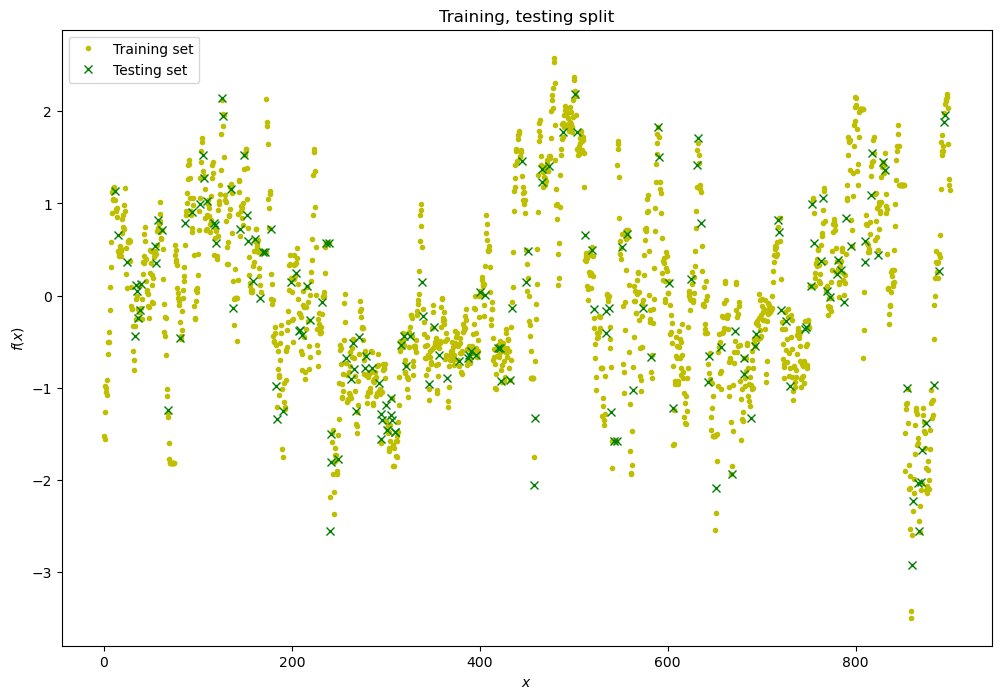

In [75]:
plt.figure(figsize=(12,8))

#plot training data
plt.plot(X_train, y_train, 'y.', markersize=6, label='Training set')

# plot testing data
plt.plot(X_test, y_test, 'gx', label='Testing set')
plt.title('Training, testing split')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')
plt.show()

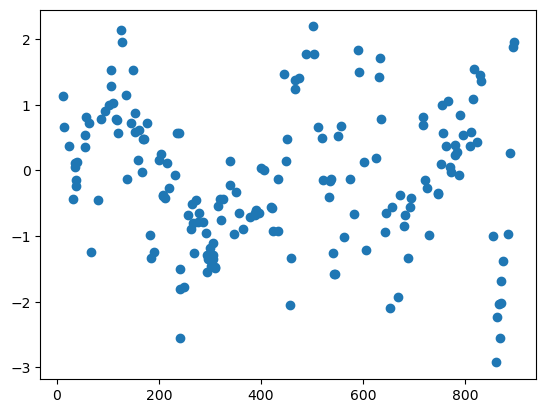

In [76]:
plt.scatter(X_test, y_test)

In [77]:
x_train = torch.tensor(X_train.to_numpy())
y_train = torch.tensor(y_train.to_numpy())

x_test = torch.tensor(X_test.to_numpy())
y_test = torch.tensor(y_test.to_numpy())

In [78]:
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel, PeriodicKernel, CosineKernel, MaternKernel
from gpytorch.distributions import MultivariateNormal
inducing_points_number = 30
inducing_points = torch.linspace(0, 900, inducing_points_number).double()
class GPRegressionModel_VAR(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel_VAR, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.base_covar_module = ScaleKernel(PeriodicKernel()+RBFKernel())
        self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points=inducing_points, likelihood=likelihood)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [79]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(PeriodicKernel()+RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [81]:

likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(torch.ones_like(x_train) * 0.01, learn_additional_noise=True)
# likelihood = gpytorch.likelihoods.GaussianLikelihood()
model_1 = GPRegressionModel_VAR(x_train, y_train, likelihood)
model_2 = GPRegressionModel(x_train, y_train, likelihood)
model = model_1

In [83]:
training_iterations = 500

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
loss_list = []
def train():
    for i in range(training_iterations):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(x_train)
        # Calc loss and backprop derivatives
        loss = -mll(output, y_train)
        loss_list.append(loss.item())
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()
        torch.cuda.empty_cache()

# See dkl_mnist.ipynb for explanation of this flag
%time train()

Iter 1/500 - Loss: 1.979
Iter 2/500 - Loss: 1.936
Iter 3/500 - Loss: 1.891
Iter 4/500 - Loss: 1.867
Iter 5/500 - Loss: 1.817
Iter 6/500 - Loss: 1.854
Iter 7/500 - Loss: 1.758
Iter 8/500 - Loss: 1.738
Iter 9/500 - Loss: 1.704
Iter 10/500 - Loss: 1.684
Iter 11/500 - Loss: 1.669
Iter 12/500 - Loss: 1.648
Iter 13/500 - Loss: 1.628
Iter 14/500 - Loss: 1.626
Iter 15/500 - Loss: 1.613
Iter 16/500 - Loss: 1.592
Iter 17/500 - Loss: 1.584
Iter 18/500 - Loss: 1.573
Iter 19/500 - Loss: 1.571
Iter 20/500 - Loss: 1.557
Iter 21/500 - Loss: 1.548
Iter 22/500 - Loss: 1.544
Iter 23/500 - Loss: 1.546
Iter 24/500 - Loss: 1.538
Iter 25/500 - Loss: 1.528
Iter 26/500 - Loss: 1.528
Iter 27/500 - Loss: 1.524
Iter 28/500 - Loss: 1.521
Iter 29/500 - Loss: 1.513
Iter 30/500 - Loss: 1.511
Iter 31/500 - Loss: 1.506
Iter 32/500 - Loss: 1.509
Iter 33/500 - Loss: 1.499
Iter 34/500 - Loss: 1.496
Iter 35/500 - Loss: 1.496
Iter 36/500 - Loss: 1.490
Iter 37/500 - Loss: 1.494
Iter 38/500 - Loss: 1.484
Iter 39/500 - Loss: 1

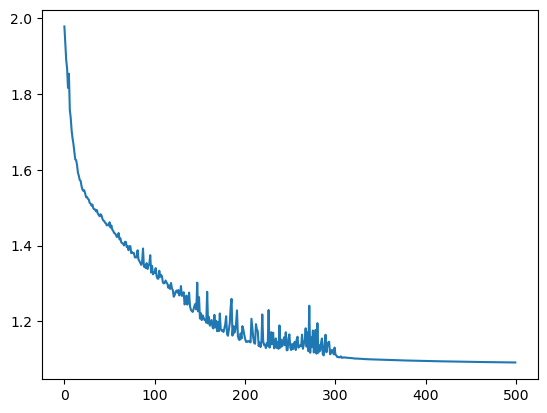

In [84]:
plt.plot(range(training_iterations), loss_list)

In [85]:
model.eval()
likelihood.eval()
with gpytorch.settings.max_preconditioner_size(10), torch.no_grad():
    test_preds = model(x_test)
    train_preds = model(x_train)
    test_inducing_points = model(inducing_points)

/Users/brett/opt/anaconda3/envs/gpytorch/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [92]:
print('Test MAE: {}'.format(torch.mean(torch.abs(test_preds.mean - y_test))))

Test MAE: 0.5221631152787215


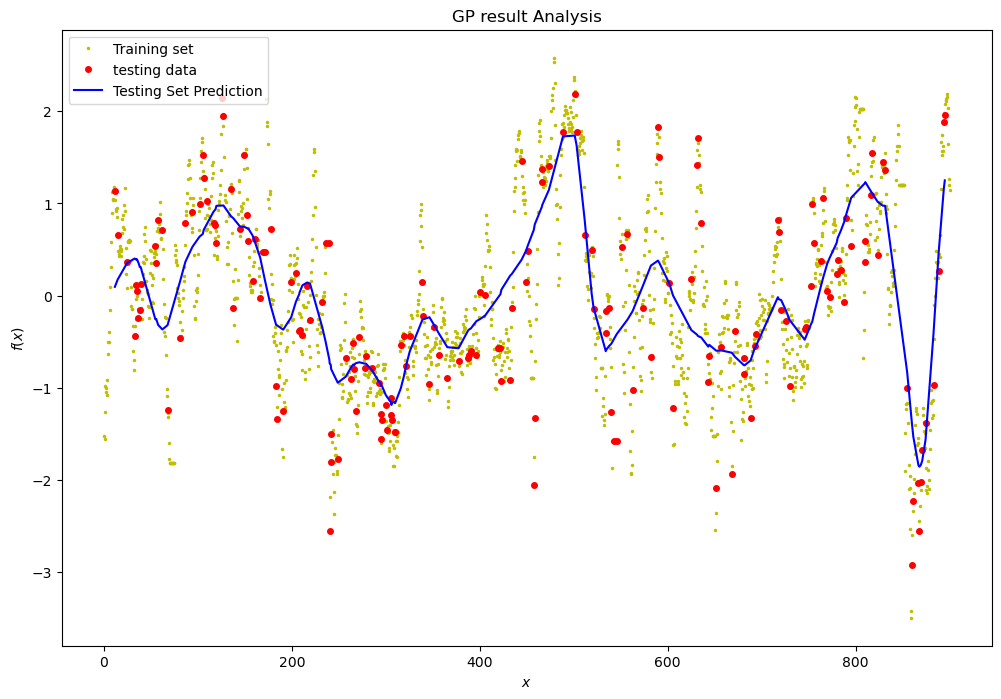

In [98]:
# y_pred_train_with_nan = np.concatenate((np.array(train_preds.mean[0:train_size])\
#     , np.array([np.nan for i in range(test_size)]), np.array(train_preds.mean[train_size:]))) 

y_pred_test = np.array(test_preds.mean)
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(figsize=(12,8))

#plot training data
plt.plot(x_train, y_train, 'y.', markersize=3, label='Training set')

#plot testing data
plt.plot(x_test, y_test, 'ro', markersize=4, label='testing data')

#plot testing prediction
plt.plot(x_test, y_pred_test, 'b-', label='Testing Set Prediction')

#plot inducing points location
#plt.plot(inducing_points, test_inducing_points.mean, 'ko', markersize = 6, label = 'inducing data')

#add CI
#plt.fill_between(np.squeeze(X_test), (y_pred_test- y_pred_test.stddev).ravel(), (y_pred_test+y_pred_test.stddev).ravel(), color='blue',alpha = 0.2)

plt.title('GP result Analysis')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')
plt.show()